Machine learning algorithms for classification problems we can use:

- Logistic Regression
- Decision Tree
- Random Forest

Based on our dataset (over 300k rows in training data and 20+ features):

- Use Random Search over Grid Search because it can find good solutions with fewer iterations and effectively handle large search spaces. We might choose Grid Search for our model for a comprehensive search for best hyperparameter but since this is only for benchmarking, I will use Random Search.

- Use KFold cross validation instead of a fixed validation set to prevent overfitting.

- Use metrics from [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) as well as ROC AUC score to measure the models' performance.

- Will only use Logistic Regression with linear features and polynomial degrees of 2 since using exponential of 3 and 4 will be too computing exhausted

**Note:** random_state will automatically set to 0 to ensure reproducable result

In [1]:
# Imports and environment setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import f1_score, roc_curve, auc, classification_report

In [2]:
df_train = pd.read_csv("../data/transformed_train.csv")
df_test = pd.read_csv("../data/transformed_test.csv")

In [3]:
# Status is the target feature
df_X = df_train.drop(["Status"], axis=1)
df_y = df_train[["Status"]]

# Splitting our training data into a train set and a validation set
train_X, val_X, train_y, val_y = train_test_split(
    df_X, df_y,
    shuffle=True,
    test_size=0.2,    # 80% Train - 20% Validation
    random_state=0
)


In [16]:
clfs = dict()  # Save all models in a dictionary for benchmarking purpose

In [17]:
cv = KFold(
    n_splits=4,     # Each fold is 20% of df_X
    shuffle=True,
    random_state=0  
)

## Logistic Regression with linear features

In [18]:
clf = LogisticRegression(
    solver="saga",            
    class_weight="balanced",
    max_iter=1000,
    random_state=0           
)

In [19]:
params = {
    "penalty": ["l1", "l2"],   # L1 and L2 regularization
    "C": 1 / np.logspace(-10, 2, num=5)
}

In [20]:
random_clf = RandomizedSearchCV(clf, params, cv=cv, n_jobs=-2, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True)
random_clf.fit(train_X, train_y.to_numpy().ravel())

clfs["logistic_linear"] = random_clf

In [21]:
random_clf.best_params_

{'penalty': 'l1', 'C': 10000000000.0}

In [22]:
train_pred_y = random_clf.predict(train_X)
val_pred_y = random_clf.predict(val_X)

train_performance_report = classification_report(train_y, train_pred_y)
val_performance_report = classification_report(val_y, val_pred_y)

print(f"Training performance\n{train_performance_report}")
print(f"Validation performance\n{val_performance_report}")

Training performance
              precision    recall  f1-score   support

           0       0.87      0.88      0.88    133766
           1       0.88      0.87      0.88    133934

    accuracy                           0.88    267700
   macro avg       0.88      0.88      0.88    267700
weighted avg       0.88      0.88      0.88    267700

Validation performance
              precision    recall  f1-score   support

           0       0.87      0.88      0.88     33547
           1       0.88      0.87      0.88     33379

    accuracy                           0.88     66926
   macro avg       0.88      0.88      0.88     66926
weighted avg       0.88      0.88      0.88     66926



## Logistic Regression with polynomial degree of 2

In [23]:
# Degree 2 Polynomial Features:
poly = PolynomialFeatures(2)
train_X_poly2 = poly.fit_transform(train_X)
val_X_poly2 = poly.transform(val_X)

# We need to scale the data again after transforming it to polynomial features
scaler = StandardScaler()
train_X_poly2 = scaler.fit_transform(train_X_poly2)
val_X_poly2 = scaler.transform(val_X_poly2)


In [24]:
random_clf = RandomizedSearchCV(clf, params, cv=cv, n_jobs=-2, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True)
random_clf.fit(train_X_poly2, train_y.to_numpy().ravel())

clfs["logistic_poly2"] = random_clf

In [25]:
random_clf.best_params_

{'penalty': 'l1', 'C': 10000000000.0}

In [26]:
train_pred_y = random_clf.predict(train_X_poly2)
val_pred_y = random_clf.predict(val_X_poly2)

train_performance_report = classification_report(train_y, train_pred_y)
val_performance_report = classification_report(val_y, val_pred_y)

print(f"Training performance\n{train_performance_report}")
print(f"Validation performance\n{val_performance_report}")

Training performance
              precision    recall  f1-score   support

           0       0.88      0.90      0.89    133766
           1       0.90      0.88      0.89    133934

    accuracy                           0.89    267700
   macro avg       0.89      0.89      0.89    267700
weighted avg       0.89      0.89      0.89    267700

Validation performance
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     33547
           1       0.90      0.88      0.89     33379

    accuracy                           0.89     66926
   macro avg       0.89      0.89      0.89     66926
weighted avg       0.89      0.89      0.89     66926



## Decision tree

In [27]:
params = {
    "max_depth": np.arange(2, 24, 2),
    "min_samples_split": np.arange(2, 10, 2),
    "ccp_alpha": np.linspace(0, 0.1, 10)       # Cost Complexity Pruning
}

In [28]:
clf = DecisionTreeClassifier(
    criterion="gini",         
    class_weight="balanced",
    random_state=0,       
    ccp_alpha=0.0
)

random_clf = RandomizedSearchCV(clf, params, cv=cv, n_jobs=-2, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True)
random_clf.fit(train_X, train_y.to_numpy().ravel())

clfs["decision_tree"] = random_clf

In [29]:
random_clf.best_params_

{'min_samples_split': 2, 'max_depth': 14, 'ccp_alpha': 0.03333333333333333}

In [30]:
train_pred_y = random_clf.predict(train_X)
val_pred_y = random_clf.predict(val_X)

train_performance_report = classification_report(train_y, train_pred_y)
val_performance_report = classification_report(val_y, val_pred_y)

print(f"Training performance\n{train_performance_report}")
print(f"Validation performance\n{val_performance_report}")

Training performance
              precision    recall  f1-score   support

           0       0.84      0.94      0.89    133766
           1       0.93      0.82      0.87    133934

    accuracy                           0.88    267700
   macro avg       0.89      0.88      0.88    267700
weighted avg       0.89      0.88      0.88    267700

Validation performance
              precision    recall  f1-score   support

           0       0.84      0.94      0.89     33547
           1       0.93      0.82      0.87     33379

    accuracy                           0.88     66926
   macro avg       0.89      0.88      0.88     66926
weighted avg       0.89      0.88      0.88     66926



## Bagged decision trees

In [31]:
params = {
    "n_estimators": np.arange(5, 25, 5),
    "max_samples": np.arange(0.1, 1.0, 0.1),
}

In [32]:
clf = BaggingClassifier(
    estimator=clfs["decision_tree"],
    random_state=0  
)

random_clf = RandomizedSearchCV(clf, params, cv=cv, n_jobs=-2, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True)
random_clf.fit(train_X, train_y.to_numpy().ravel())

clfs["bagged_trees"] = random_clf

In [33]:
random_clf.best_params_

{'n_estimators': 5, 'max_samples': 0.8}

## Feature bagged decision trees

In [34]:
params = {
    "n_estimators": np.arange(5, 25, 5),
    "max_samples": np.arange(0.1, 1.0, 0.1),
    "max_features": [0.5, 0.7, 0.9],  # Specify different fractions of features to consider for each base estimator
}

In [35]:
clf = BaggingClassifier(estimator=clfs["decision_tree"], random_state=0, bootstrap_features=True)

random_clf = RandomizedSearchCV(clf, params, cv=cv, n_jobs=-2, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True)
random_clf.fit(train_X, train_y.to_numpy().ravel())

clfs["feature_bagged_trees"] = random_clf

In [36]:
random_clf.best_params_

{'n_estimators': 5, 'max_samples': 0.6, 'max_features': 0.9}

In [37]:
train_pred_y = random_clf.predict(train_X)
val_pred_y = random_clf.predict(val_X)

train_performance_report = classification_report(train_y, train_pred_y)
val_performance_report = classification_report(val_y, val_pred_y)

print(f"Training performance\n{train_performance_report}")
print(f"Validation performance\n{val_performance_report}")

Training performance
              precision    recall  f1-score   support

           0       0.98      0.97      0.97    133766
           1       0.97      0.98      0.97    133934

    accuracy                           0.97    267700
   macro avg       0.97      0.97      0.97    267700
weighted avg       0.97      0.97      0.97    267700

Validation performance
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     33547
           1       0.94      0.97      0.95     33379

    accuracy                           0.95     66926
   macro avg       0.95      0.95      0.95     66926
weighted avg       0.95      0.95      0.95     66926



## Random forest

In [38]:
params = {
    "n_estimators": np.arange(5, 25, 5),
    "max_depth": np.arange(2, 24, 2),
}

In [39]:
clf = RandomForestClassifier(
    criterion="gini", 
    class_weight="balanced",
    random_state=0     
)

random_clf = RandomizedSearchCV(clf, params, cv=cv, n_jobs=-2, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True)
random_clf.fit(train_X, train_y.to_numpy().ravel())

clfs["random_forest"] = random_clf

In [40]:
random_clf.best_params_

{'n_estimators': 10, 'max_depth': 20}

In [41]:
train_pred_y = random_clf.predict(train_X)
val_pred_y = random_clf.predict(val_X)

train_performance_report = classification_report(train_y, train_pred_y)
val_performance_report = classification_report(val_y, val_pred_y)

print(f"Training performance\n{train_performance_report}")
print(f"Validation performance\n{val_performance_report}")

Training performance
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    133766
           1       0.99      1.00      1.00    133934

    accuracy                           1.00    267700
   macro avg       1.00      1.00      1.00    267700
weighted avg       1.00      1.00      1.00    267700

Validation performance
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     33547
           1       0.97      0.99      0.98     33379

    accuracy                           0.98     66926
   macro avg       0.98      0.98      0.98     66926
weighted avg       0.98      0.98      0.98     66926



# Model benchmark

Model             ROC_AUC        F1
-----------------------------------
logistic_linear   0.94896   0.87617
logistic_poly2    0.95499   0.88835
decision_tree     0.91939   0.87276
bagged_trees      0.99615   0.97055
feature_bagged_trees   0.99034   0.95448
random_forest     0.99806   0.98059


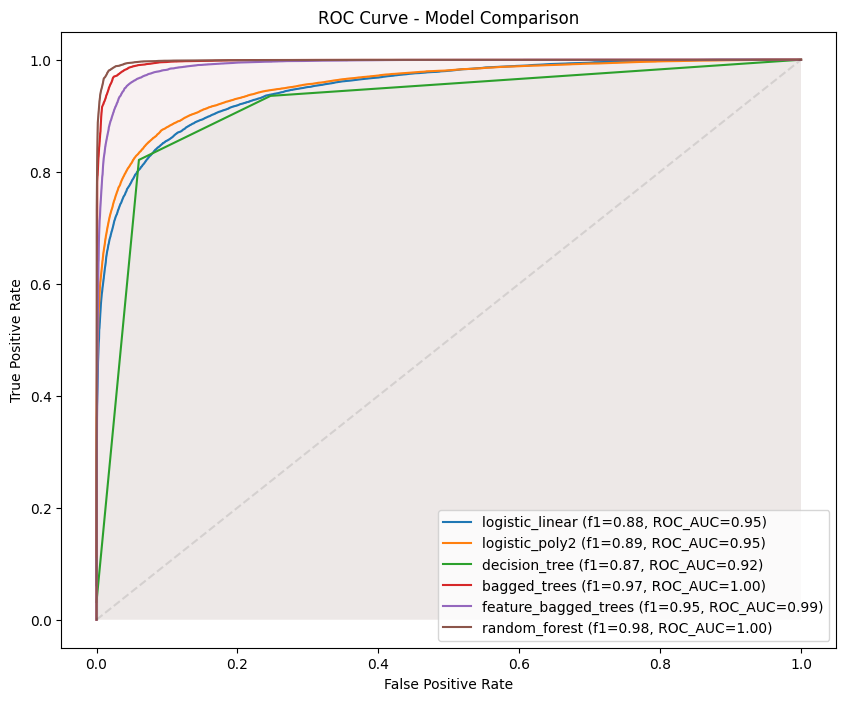

In [44]:
fig, axis = plt.subplots(figsize=(10, 8))

print(f"{'Model':15}{'ROC_AUC':>10}{'F1':>10}")
print("-" * 35)
for name, clf in clfs.items():
    if name == "logistic_poly2":
        prob_y = clf.predict_proba(val_X_poly2)[:, 1]
        pred_y = clf.predict(val_X_poly2)
    else:
        prob_y = clf.predict_proba(val_X)[:, 1]
        pred_y = clf.predict(val_X)

    fpr, tpr, thresholds = roc_curve(val_y, prob_y)
    roc_auc = auc(fpr, tpr)
    sns.lineplot(x=fpr, y=tpr, label=f"{name} (f1={f1_score(val_y, pred_y):.2f}, ROC_AUC={roc_auc:.2f})", ax=axis)
    plt.fill_between(fpr, tpr, alpha=0.024)
    print(f"{name:15}{roc_auc:10.5f}{f1_score(val_y, pred_y):10.5f}")


plt.plot([0, 1], [0, 1], linestyle="--", color="black", alpha=0.1)
axis.set_xlabel("False Positive Rate")
axis.set_ylabel("True Positive Rate")
axis.set_title("ROC Curve - Model Comparison")
axis.legend()

plt.show()
fig.savefig("../images/models_roc_auc_compare.png")

Based on the benchmark, we can see that most model performed well but bagged trees and random forest displayed highest f1 and ROC_AUC score. Also the tree models is not overfitted since they are performing well against validation dataset (f1: 0.98)

For final model optimization, I will use random forest for its superiority in computing time comparing to bagged trees